In [1]:
from spacy.lang.pl import Polish
from spacy.tokenizer import Tokenizer
nlp = Polish()
tokenizer = Tokenizer(nlp.vocab)

In [2]:
from os import listdir
from os.path import isfile,join
billPath = './bills/'
bills = [f for f in listdir(billPath) if isfile(join(billPath, f))]

bills_bigrams = {}
bills_trigrams = {}
bills_single_grams = {}
# bills_bigram_list = []

for b in bills:
    bPath = billPath + b
    f = open(bPath,encoding='utf-8')
    content = f.read()
    content = content.lower()
    tokens = tokenizer(content)
    frequency = {}
    
    for t in range(len(tokens)-1):
        k1 = tokens[t].text
        k2 = tokens[t + 1].text
        bigram = (k1,k2)
        bills_bigrams[(k1,k2)] = bills_bigrams.get((k1,k2),0) + 1
        bills_single_grams[k1] = bills_single_grams.get(k1,0) + 1
    for t in range(len(tokens)-2):
        k1 = tokens[t].text
        k2 = tokens[t + 1].text
        k3 = tokens[t + 2].text
        bills_trigrams[(k1,k2,k3)] = bills_trigrams.get((k1,k2,k3),0) + 1
        
    k1 = tokens[len(tokens)-1]
    bills_single_grams[k1] = bills_single_grams.get(k1,0) + 1

In [3]:
len(bills_bigrams)

1097691

In [5]:
import regex as re
to_remove = []

for i in bills_bigrams:
    t1,t2 = i
    tmp1,tmp2 = re.search(r"\p{L}+",t1),re.search(r"\p{L}+",t2)
    if tmp1 is None or tmp2 is None or len(tmp1.group(0)) != len(t1) or len(tmp2.group(0)) != len(t2) :
        to_remove += [(t1,t2)]

len(to_remove)

657079

In [6]:
for i in to_remove:
    bills_bigrams.pop(i)
len(bills_bigrams)

440612

In [7]:
from math import log

bills_bigrams_with_PMI = {}

for i in bills_bigrams:
    t1, t2 = i
    f1, f2, f12 = bills_single_grams[t1], bills_single_grams[t2], bills_bigrams[(t1,t2)]
    bills_bigrams_with_PMI[(t1,t2)] = (f1,f2,f12,log(f12/(f1*f2)))
    


In [8]:
# Sort the word pairs according to that measure in the descending order and determine top 10 entries.
list_PMI = []
for i in bills_bigrams_with_PMI:
    list_PMI.append([i,bills_bigrams_with_PMI[i][3],bills_bigrams_with_PMI[i][2]])
list_PMI.sort(key=lambda a: -a[1])
    

In [9]:
list_PMI[0:10]

[[('kołowe', 'jednoosiowe'), 0.0, 1],
 [('automatyki', 'grzewczej'), 0.0, 1],
 [('prefabrykatów', 'wnętrzowe'), 0.0, 1],
 [('gołe', 'aluminiowe'), 0.0, 1],
 [('polistyrenu', 'spienionego'), 0.0, 1],
 [('objaśnieniem', 'figur'), 0.0, 1],
 [('wkładzie', 'wnoszonym'), 0.0, 1],
 [('doktorem', 'habilitowanym'), 0.0, 1],
 [('naruszonymi', 'plombami'), 0.0, 1],
 [('zaniedbanej', 'wychowawczo'), 0.0, 1]]

In [10]:
filtered_PMI = [ t for t in list_PMI if t[2] > 4]

In [11]:
filtered_PMI[0:10]

[[('świeckie', 'przygotowujące'), -1.6094379124341003, 5],
 [('ręcznego', 'miotacza'), -1.6094379124341003, 5],
 [('młyny', 'kulowe'), -1.6094379124341003, 5],
 [('zaszkodzić', 'wynikom'), -1.6094379124341003, 5],
 [('grzegorz', 'schetyna'), -1.6094379124341003, 5],
 [('mleczka', 'makowego'), -1.791759469228055, 5],
 [('przeponowe', 'rurowe'), -1.791759469228055, 5],
 [('adama', 'mickiewicza'), -1.791759469228055, 6],
 [('papierem', 'wartościowym'), -1.9459101490553135, 5],
 [('chwytów', 'obezwładniających'), -1.9459101490553135, 5]]

In [12]:
from math import log
import numpy as np

# Data

all_occurences = 0
for i in bills_bigrams:
    all_occurences += bills_bigrams[i]

bills_bigrams_with_LLR = {}

def H(args,N):
    s = 0
    for a in args:
        a /= N
        one = 1 if a == 0 else 0
        s += a * log(a + one)
    return s

def LLR_bigram(t1,t2,N):
    t1,t2 = i
    N = all_occurences
    
    k11 = (bills_bigrams[(t1,t2)])
    k12 = (bills_single_grams[t2] - k11)
    k21 = (bills_single_grams[t1] - k11)
    k22 = (all_occurences - k11 - k12 - k21)
    
    return 2 * N * (H([k11,k12,k21,k22],N) - H([k11+k12,k21+k22],N) - H([k11+k21,k12+k22],N))
    
N = all_occurences
for i in bills_bigrams:
    t1,t2 = i    
#     k11 = (bills_bigrams[(t1,t2)])
#     k12 = (bills_single_grams[t2] - k11)
#     k21 = (bills_single_grams[t1] - k11)
#     k22 = (all_occurences - k11 - k12 - k21)
    
#     LLR = 2 * N * (H([k11,k12,k21,k22],N) - H([k11+k12,k21+k22],N) - H([k11+k21,k12+k22],N))
    
    LLR = LLR_bigram(t1,t2,N)

    bills_bigrams_with_LLR[(t1,t2)] = LLR

In [13]:
list_LLR = []
for i in bills_bigrams_with_LLR:
    list_LLR.append([i,bills_bigrams_with_LLR[i]])
list_LLR.sort(key=lambda a: -a[1])
list_LLR[0:10]

[[('mowa', 'w'), 124645.83146718914],
 [('których', 'mowa'), 97656.02403137869],
 [('o', 'których'), 68833.82784639853],
 [('którym', 'mowa'), 64283.83923316678],
 [('dodaje', 'się'), 59756.50172767568],
 [('do', 'spraw'), 50379.07917977016],
 [('o', 'którym'), 46855.915324589136],
 [('w', 'w'), 42404.08935560332],
 [('stosuje', 'się'), 40152.69589803207],
 [('minister', 'właściwy'), 39356.628900809366]]

In [15]:
import regex as re
to_remove = []

def fremove_token(t):
    tmp = re.search(r"\p{L}+",t)
    if tmp is None or len(tmp.group(0)) != len(t):
        return True
    return False
    
for i in bills_trigrams:
    t1,t2,t3 = i
    if fremove_token(t1) or fremove_token(t2) or fremove_token(t3):
        to_remove += [(t1,t2,t3)]

len(to_remove)

1629877

In [16]:
len(bills_trigrams)

2354226

In [17]:
for i in to_remove:
    bills_trigrams.pop(i)
len(bills_trigrams)

724349

In [35]:
bills_trigrams_with_PMI = {}

for i in bills_trigrams:
    t1, t2, t3 = i
    f1, f2, f3, f123 = bills_single_grams[t1], bills_single_grams[t2],bills_single_grams[t3] , bills_trigrams[(t1,t2,t3)]
    bills_trigrams_with_PMI[(t1,t2,t3)] = (f1,f2,f3,f123,log(f123/(f1*f2*f3)))
    

In [38]:
list_trigrams_PMI = []
for i in bills_trigrams_with_PMI:
    list_trigrams_PMI.append([i,bills_trigrams_with_PMI[i][3],bills_trigrams_with_PMI[i][4]]) # tokens, together,
    
list_trigrams_PMI = [ t for t in list_trigrams_PMI if t[1] > 4]
list_trigrams_PMI.sort(key=lambda a: -a[2])
list_trigrams_PMI[0:10]

[[('piłce', 'nożnej', 'uefa'), 9, -5.2293244950610855],
 [('profilem', 'zaufanym', 'epuap'), 8, -5.247681750579457],
 [('religijne', 'uroczystości', 'pogrzebowe'), 6, -5.288267030694535],
 [('finałowego', 'turnieju', 'mistrzostw'), 6, -5.306616169362732],
 [('potwierdzonym', 'profilem', 'zaufanym'), 11, -5.565216786180919],
 [('turnieju', 'mistrzostw', 'europy'), 6, -5.568980433830223],
 [('grożącą', 'jemu', 'samemu'), 5, -6.171282973683818],
 [('bankowemu', 'funduszowi', 'gwarancyjnemu'), 5, -6.238324625039508],
 [('komunalne', 'osady', 'ściekowe'), 5, -6.269096283706261],
 [('konfesyjne', 'nauczanie', 'religii'), 5, -6.29156913955832]]

In [43]:
from math import log
import numpy as np

# Data

all_occurences_trigram = 0
for i in bills_trigrams:
    all_occurences_trigram += bills_trigrams[i]


bills_trigrams_with_LLR = {}


N = all_occurences_trigram

for i in bills_trigrams:
    # we treat t1t2 and t3 as singlegram
    t1,t2,t3  = i
    
    k11 = (bills_trigrams[(t1,t2,t3)])
    k12 = (bills_single_grams[t3] - k11)
    k21 = (bills_bigrams[(t1,t2)] - k11)
    k22 = (all_occurences_trigram - k11 - k12 - k21)
    
    LLR = 2 * N * (H([k11,k12,k21,k22],N) - H([k11+k12,k21+k22],N) - H([k11+k21,k12+k22],N))

    bills_trigrams_with_LLR[(t1,t2,t3)] = LLR

In [45]:
list_trigrams_LLR = []
for i in bills_trigrams_with_LLR:
    list_trigrams_LLR.append([i,bills_trigrams_with_LLR[i]])
list_trigrams_LLR.sort(key=lambda a: -a[1])
list_trigrams_LLR[0:10]

[[('o', 'których', 'mowa'), 92100.04972834075],
 [('o', 'którym', 'mowa'), 62646.7332030165],
 [('których', 'mowa', 'w'), 47739.06848574327],
 [('właściwy', 'do', 'spraw'), 44653.074728556625],
 [('o', 'której', 'mowa'), 35850.49113124134],
 [('którym', 'mowa', 'w'), 32449.770015804836],
 [('ustawie', 'z', 'dnia'), 31176.668053809528],
 [('zastępuje', 'się', 'wyrazami'), 25215.325587729756],
 [('minister', 'właściwy', 'do'), 24519.717879464166],
 [('wejścia', 'w', 'życie'), 23589.36245948675]]

# Comparison table regarding 11 task
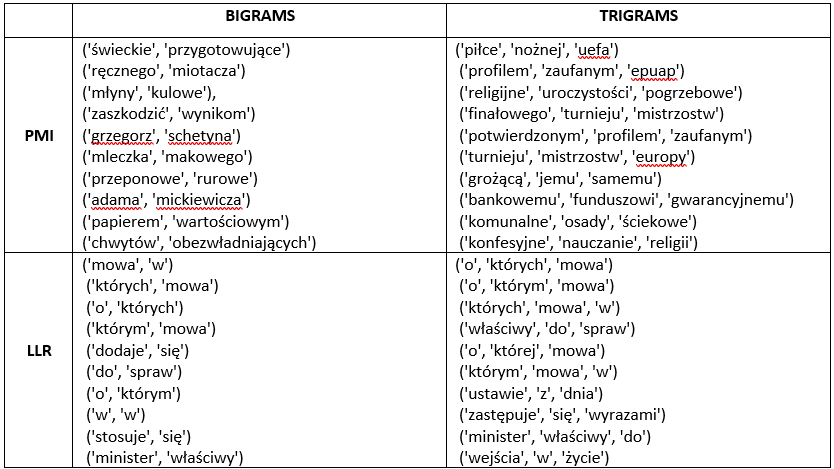



# Answer the following questions:
    Why do we have to filter the bigrams, rather than the token sequence?
        Consider this sequence: "for 24 dollars"
        We have 3 tokens: 'for' '24' 'dollars'
        
        1) filtering tokens and creating bigrams: 
           'for' 'dollars'
           bigrams found ('for', 'dollars')
           
        2) creating bigrams and filtering them:
            bigrams found: ('for', '24') , ('24', 'dollars')
            bigrams after filtering: None
        
        In first case the approach found bigram that does not exists
        Second approach is correct because it haven't found any valid bigram
    
    Which measure (PMI, PMI with filtering, LLR) works better for the bigrams and which for the trigrams?
        For bigrams LLR worked best - because sequence found have more occurences than almost minimal. 
        Both PMI and PMI wth filtering  found unique sequences which separatly does not appear 
        
        There is similar situation regarding trigrams. But PMI found uniquely connected sequences like 'piłce', 'nożnej', 'uefa'
    What types of expressions are discovered by the methods.
        As said before 
            PMI - unique sequences that only appear together
            LLR - most common sequences that appear togather
            
    Can you devise a different type of filtering that would yield better results?
        1) Maybe merging two of these methods. 
            Taking ranks of each sequence in each method then makinmg average or weighted average to balance the finale result.
        2) Taking PMI result but make the filter more restrictive, i mean more occurences in text.